# TensorBoard

## Dependencies

Note: the following dependencies were **not included** in the project's requirements file:
* tensorflow
* tensorboard
* torch

In [1]:
# Load in the used dependencies
import os
import numpy as np
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data

### Hyperparameters

In [2]:
LOG_DIR = './population_backup/storage/experiment6/data_neat/'
topology_id = 2
overwrite = True
rm_duplicates = False  # Remove all samples with at least 'dup_columns' duplicate values
dup_columns = 5  # Number of duplicated columns a single sample has before removal
perfect_score = True  # Filter to only contain samples that solve the problem

### Fetch

In [3]:
# Setup the header
head = ["fitness",
        'bias_r', 'bias_z', 'bias_h',
        'weight_xr', 'weight_xz', 'weight_xh',
        'weight_hr', 'weight_hz', 'weight_hh']
if topology_id == 1:
    head += ['conn1', 'conn2']
elif topology_id == 2:
    head += ['base_rw', 'conn2']
else: 
    raise Exception(f"Topology-ID {topology_id} not supported!")

In [4]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_{topology_id}.csv')
data_path = os.path.join(LOG_DIR, f'data_{topology_id}.tsv')
meta_path = os.path.join(LOG_DIR, f'meta_{topology_id}.tsv')

# Load in the data (without header)
if not overwrite and os.path.exists(data_path):
    data = np.genfromtxt(data_path, delimiter='\t')
    meta = np.genfromtxt(meta_path, delimiter='\t')
else:
    raw = np.genfromtxt(raw_path, delimiter=',')[1:]
    data = raw[:,:-1]
    meta = raw[:,-1]
    np.savetxt(data_path, data, delimiter='\t')
    np.savetxt(meta_path, meta, delimiter='\t')

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (33497, 11)
Meta shape: (33497,)


In [5]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head[1:])
meta_pd = pd.DataFrame(meta, columns=head[:1])

In [6]:
data_pd.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,base_rw,conn2
0,1.315464,2.528098,-0.523398,-0.939430,-0.784320,5.826999,0.856270,1.137163,-2.230395,0.966771,-2.943269
1,1.315464,2.426110,-0.523398,-3.481500,-0.720074,5.808579,2.278459,0.963990,-2.214103,0.993608,-3.411810
2,1.315464,2.426110,-0.523398,-3.481500,-0.945465,5.808579,1.997678,1.216224,-2.214103,0.993608,-3.411810
3,1.315464,2.426110,-0.523398,-3.481500,-0.720074,5.808579,2.065527,0.963990,-2.214103,0.993608,-3.411810
4,1.315464,2.426110,-0.523398,-3.434384,-0.720074,5.808579,2.278459,0.963990,-2.214103,0.993608,-3.411810


In [7]:
meta_pd.head()

,fitness
0,0.833333
1,0.888889
2,0.888889
3,0.833333
4,0.833333


### Filter the data

In [8]:
# Filter out the complete duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (24760, 11)
Meta shape: (24760, 1)


In [9]:
# For example, if you want to see only fitnesses of 1 (perfect score).
if perfect_score:
    indices = meta_pd == 1
    data_pd = data_pd[indices.values]
    meta_pd = meta_pd[indices.values]
    print(f"Data shape: {data_pd.shape}")
    print(f"Meta shape: {meta_pd.shape}")

Data shape: (9825, 11)
Meta shape: (9825, 1)


In [10]:
# Filter out all the samples that have at least one duplicate value (in each of its columns)
if rm_duplicates:
    indices = (meta_pd<0).astype(int).values.flatten()  # Little hack
    for h in head[1:]:
        indices += data_pd.duplicated(subset=h).astype(int).values

    # Remove all that exceed the set threshold
    data_pd = data_pd[indices < dup_columns]
    meta_pd = meta_pd[indices < dup_columns]
    print(f"Dropping duplicates that occur in {dup_columns} columns or more")
    print(f" > Data shape: {data_pd.shape}")
    print(f" > Meta shape: {meta_pd.shape}")

In [11]:
data_pd

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,base_rw,conn2
17,1.706957,2.426110,-0.523398,1.205017,-0.720074,6.000000,2.278459,1.136844,-2.106582,0.993608,-3.411810
21,1.706957,2.426110,-0.319797,-0.651949,-0.602082,5.519592,1.885862,0.433089,-2.099491,0.993608,-3.836359
25,2.003657,2.426110,-0.319797,-0.660571,-0.681661,5.519592,2.204803,0.390504,-2.105876,0.993608,-3.836359
26,1.997316,2.426110,-0.319797,-0.651949,-0.602082,5.786108,1.885862,0.433089,-2.265002,0.993608,-3.836359
30,1.596965,2.426110,-0.319797,-0.399041,-0.602082,5.519592,2.066884,0.433089,-2.099491,0.993608,-3.836359
...,...,...,...,...,...,...,...,...,...,...,...
33479,1.680429,1.233089,0.056502,2.009863,-0.816771,1.825239,-1.407597,1.403033,0.378181,0.042094,-3.342709
33482,2.296208,1.233089,0.056502,2.378008,-0.687034,1.825239,-1.105349,1.403033,0.362428,0.042094,-3.465918
33486,2.296208,1.233089,0.056502,2.378008,-0.908648,1.825239,-1.155909,1.403033,0.378181,0.042094,-3.465918
33490,2.296208,1.126165,0.056502,2.009863,-0.978611,1.825239,-1.407597,1.442977,0.378181,0.042094,-3.465918


### Visualize the data

Remark: Symmetry in data clearly by conn1 (this is the connection between GRU node and output of the global network) 

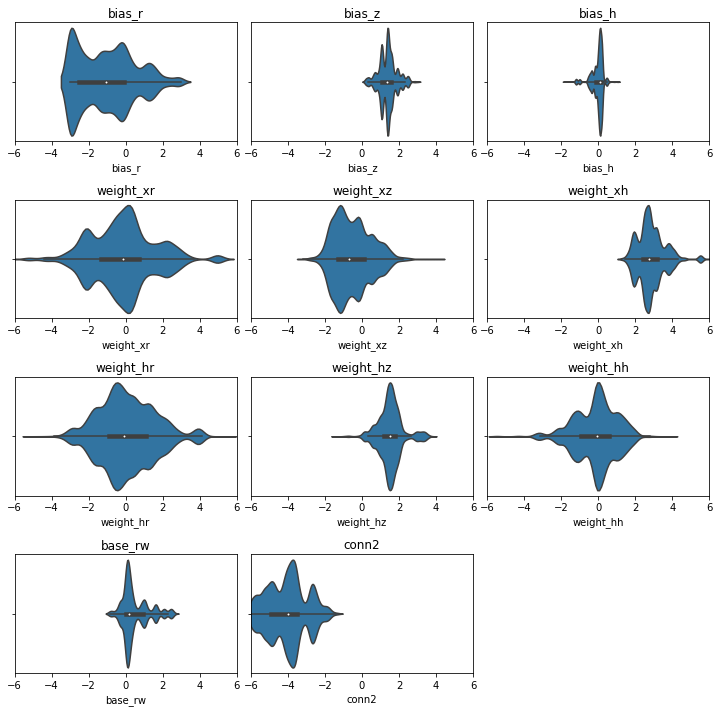

In [12]:
plt.figure(figsize=(10,10))
for i, h in enumerate(head[1:]):
    plt.subplot(4,3,i+1)
    sns.violinplot(data_pd[h])
    plt.title(h)
    plt.xlim(-6,6)
plt.tight_layout()
plt.show()
plt.close()

### Format

Create labels for visualisation.

In [13]:
# Create better labels
meta_str = []
for d, m in zip(data_pd.values, meta_pd.values):
    s = [str(round(m[0], 2))]
    s += [str(round(x, 5)) for x in d]
    meta_str.append(s)   

# Example
print(f"Data example: \n> {data_pd.values[0]}")
print(f"Label example: \n> {meta_str[0]}")
print(f"For header: \n> {head}")

Data example: 
> [ 1.70695656  2.4261102  -0.52339824  1.20501661 -0.72007367  6.
  2.27845867  1.13684425 -2.10658185  0.99360765 -3.41180996]
Label example: 
> ['1.0', '1.70696', '2.42611', '-0.5234', '1.20502', '-0.72007', '6.0', '2.27846', '1.13684', '-2.10658', '0.99361', '-3.41181']
For header: 
> ['fitness', 'bias_r', 'bias_z', 'bias_h', 'weight_xr', 'weight_xz', 'weight_xh', 'weight_hr', 'weight_hz', 'weight_hh', 'base_rw', 'conn2']


## Magic

Folder in which data is stored is "runs/topology_1" (always keep "runs"). Change this is you want to compare several configurations.

In [14]:
# Fire up the TensorBoard
writer = SummaryWriter(log_dir=f"runs/topology_{topology_id}")  # Overwrites if already exists
writer.add_embedding(data_pd.to_numpy(), meta_str, metadata_header=head)
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

# Tensorboard can be opened in separate tab: localhost:6006

Reusing TensorBoard on port 6006 (pid 21520), started 0:17:23 ago. (Use '!kill 21520' to kill it.)